pH

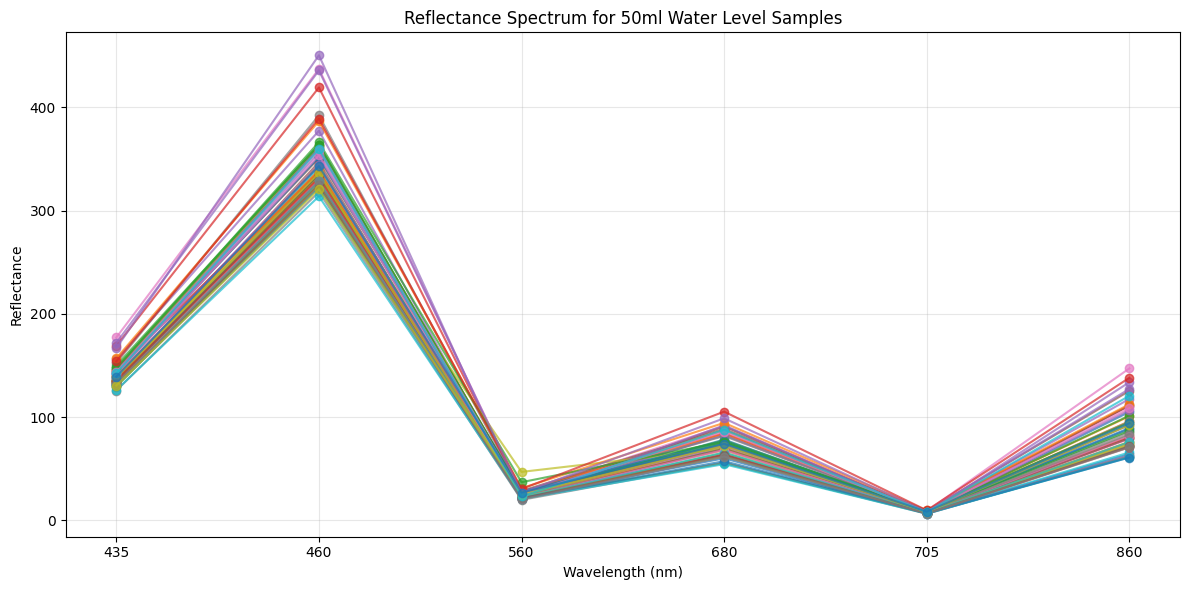

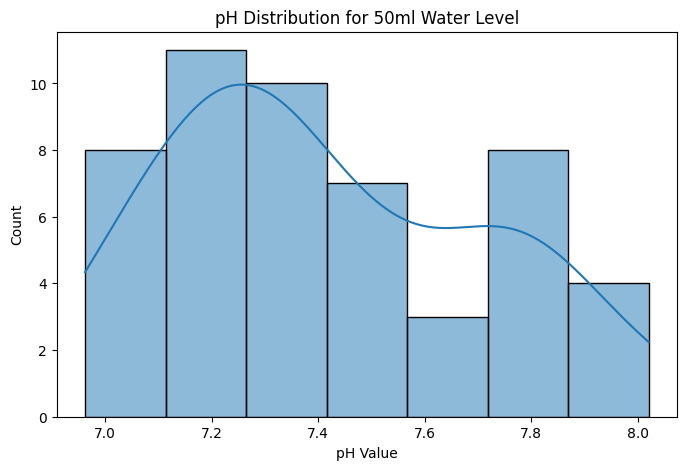

In [6]:
#pH graph - 50 ml
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Custom Dataset Class
class SpectralDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Transformer Model
class SpectralTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim=64, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Sequential(
            nn.Linear(embed_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        x = self.embedding(x)
        x = self.transformer(x)
        x = x.mean(dim=1)  # Mean pooling
        return self.regressor(x)

def plot_50ml_spectral_data(df):
    """Plot spectral data specifically for 50ml water level"""
    df_50ml = df[df['water_level'] == '50ml']
    if len(df_50ml) == 0:
        print("No 50ml data available for plotting")
        return

    wavelengths = ['435', '460', '560', '680', '705', '860']
    available_wavelengths = [wl for wl in wavelengths if wl in df_50ml.columns]
    if not available_wavelengths:
        print("No wavelength data available for 50ml samples")
        return

    plt.figure(figsize=(12, 6))
    for _, sample in df_50ml.iterrows():
        ph = sample['Ph']
        reflectance = sample[available_wavelengths]
        plt.plot(available_wavelengths, reflectance, 'o-', alpha=0.7, label=f'pH {ph:.2f}')

    plt.title('Reflectance Spectrum for 50ml Water Level Samples')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.grid(True, alpha=0.3)
    if len(df_50ml) <= 15:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # pH Distribution
    plt.figure(figsize=(8, 5))
    sns.histplot(df_50ml['Ph'], kde=True)
    plt.title('pH Distribution for 50ml Water Level')
    plt.xlabel('pH Value')
    plt.ylabel('Count')
    plt.show()

# Load Data and Plot Only
df = pd.read_csv('/content/merged_soildataset_updated.csv')
df['water_level'] = df['Records'].str.extract(r'(\d+)ml')[0] + 'ml'
df = df[df['water_level'] == '50ml']  # Focus only on 50ml samples
df = df.dropna(subset=['Ph'])
plot_50ml_spectral_data(df)


Starting script execution...
Loading and preprocessing data...

Water level distribution:
water_level
25ml    52
0ml     51
50ml    51
Name: count, dtype: int64


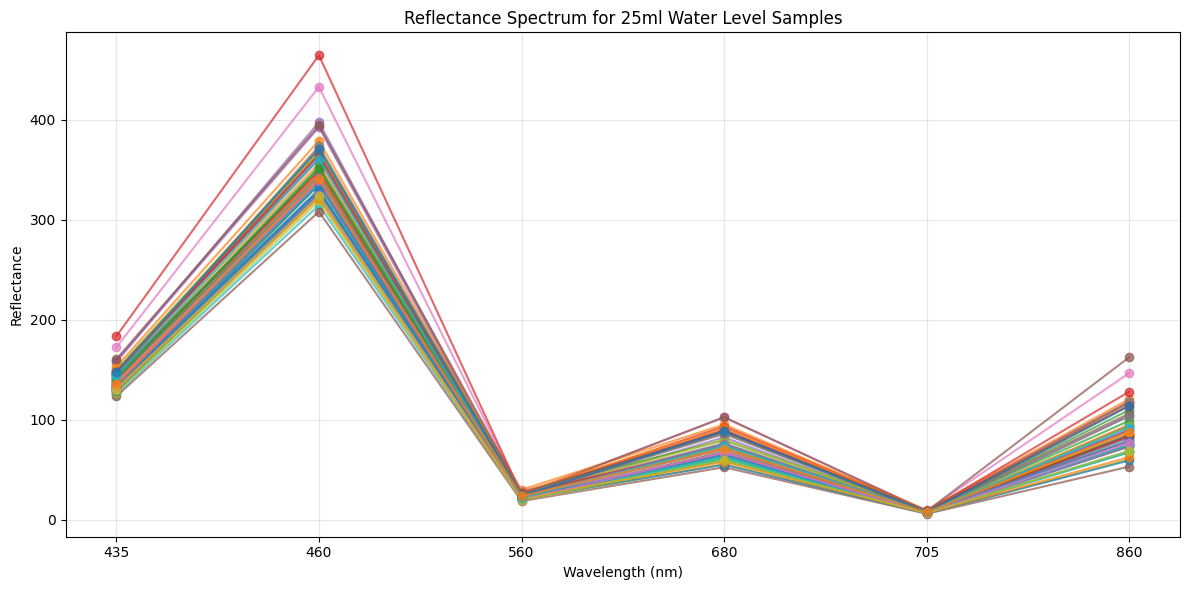

Script execution completed.


In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import copy

# Custom Dataset Class
class SpectralDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Transformer Model
class SpectralTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim=64, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Sequential(
            nn.Linear(embed_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        x = self.embedding(x)
        x = self.transformer(x)
        x = x.mean(dim=1)  # Mean pooling
        return self.regressor(x)

def calculate_accuracy(true_values, pred_values):
    """Calculate accuracy as max(r2_score*100, 100*(1-rmse))"""
    r2 = r2_score(true_values, pred_values)
    rmse = np.sqrt(mean_squared_error(true_values, pred_values))
    accuracy = max(r2 * 100, 100 * (1 - rmse))
    return accuracy

def train_model(model, train_loader, val_loader, epochs=100, lr=0.001, device='cpu'):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_accuracy = -float('inf')
    best_model = None

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                val_preds.extend(outputs.cpu().numpy().flatten())
                val_true.extend(y_val.cpu().numpy())

        val_accuracy = calculate_accuracy(val_true, val_preds)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = copy.deepcopy(model.state_dict())

        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Loss: {train_loss / len(train_loader):.4f}, Val Accuracy: {val_accuracy:.1f}%')

    if best_model:
        model.load_state_dict(best_model)

    return model

def evaluate_model(model, test_loader, device='cpu'):
    model.eval()
    test_preds = []
    test_true = []
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = model(X_test)
            test_preds.extend(outputs.cpu().numpy().flatten())
            test_true.extend(y_test.cpu().numpy())

    accuracy = calculate_accuracy(test_true, test_preds)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.scatter(test_true, test_preds, alpha=0.7)
    plt.plot([min(test_true), max(test_true)], [min(test_true), max(test_true)], 'k--')
    plt.xlabel('True pH Values')
    plt.ylabel('Predicted pH Values')
    plt.title(f'Model Performance\nAccuracy: {accuracy:.1f}%')
    plt.grid(True, alpha=0.3)
    plt.show()

    return accuracy

def plot_25ml_spectral_data(df):
    """Plot spectral data specifically for 25ml water level"""
    df_25ml = df[df['water_level'] == '25ml']

    if df_25ml.empty:
        print("No 25ml data available for plotting")
        return

    wavelengths = ['435', '460', '560', '680', '705', '860']
    available_wavelengths = [wl for wl in wavelengths if wl in df_25ml.columns]

    if not available_wavelengths:
        print("No wavelength data available for 25ml samples")
        return

    plt.figure(figsize=(12, 6))
    for _, sample in df_25ml.iterrows():
        ph = sample['Ph']
        reflectance = sample[available_wavelengths]
        plt.plot(available_wavelengths, reflectance, 'o-', alpha=0.7, label=f'pH {ph:.2f}')

    plt.title('Reflectance Spectrum for 25ml Water Level Samples')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.grid(True, alpha=0.3)

    if len(df_25ml) <= 15:
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()

def main():
    print("Loading and preprocessing data...")
    df = pd.read_csv('merged_soildataset_updated.csv')

    df['water_level'] = df['Records'].str.extract(r'(\d+)ml')[0] + 'ml'
    df = df[df['water_level'].isin(['0ml', '25ml', '50ml'])].dropna(subset=['Ph'])

    print("\nWater level distribution:")
    print(df['water_level'].value_counts())

    plot_25ml_spectral_data(df)

if __name__ == "__main__":
    print("Starting script execution...")
    main()
    print("Script execution completed.")


Loading and preprocessing data...
Plotting wavelength visualization...


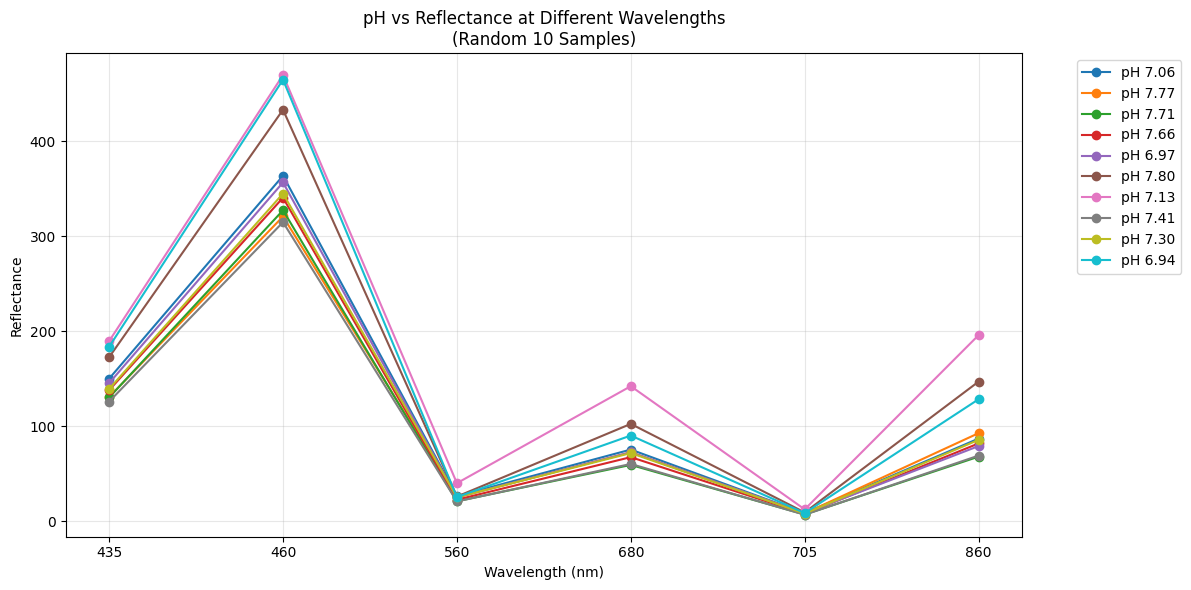

Performing feature engineering...
Using features: ['log_435', 'log_460', 'log_560', 'log_680', 'log_705', 'log_860', 'ratio_560_435', 'ratio_680_560', 'water_level_encoded']

=== Processing 0ml ===
Epoch 0: Loss: 49.6356, Val Accuracy: -536.6%
Epoch 10: Loss: 0.3810, Val Accuracy: 67.9%
Epoch 20: Loss: 0.0921, Val Accuracy: 64.5%
Epoch 30: Loss: 0.0868, Val Accuracy: 64.9%
Epoch 40: Loss: 0.0955, Val Accuracy: 67.0%
Epoch 50: Loss: 0.0841, Val Accuracy: 66.0%
Epoch 60: Loss: 0.0754, Val Accuracy: 69.1%
Epoch 70: Loss: 0.0889, Val Accuracy: 66.4%
Epoch 80: Loss: 0.0740, Val Accuracy: 73.2%
Epoch 90: Loss: 0.0643, Val Accuracy: 72.8%


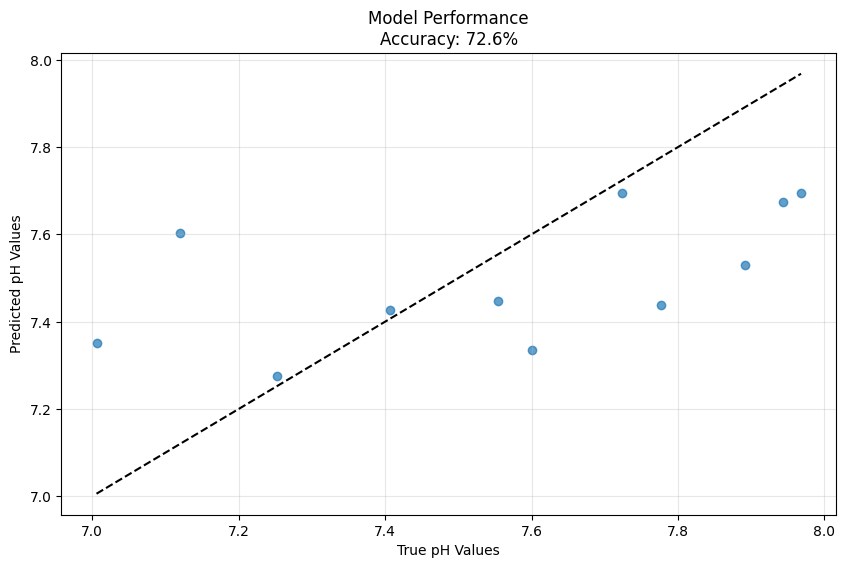


=== Processing 25ml ===
Epoch 0: Loss: 45.0691, Val Accuracy: -468.7%
Epoch 10: Loss: 0.1216, Val Accuracy: 28.6%
Epoch 20: Loss: 0.0834, Val Accuracy: 50.0%
Epoch 30: Loss: 0.0741, Val Accuracy: 56.7%
Epoch 40: Loss: 0.0497, Val Accuracy: 53.9%
Epoch 50: Loss: 0.0581, Val Accuracy: 54.1%
Epoch 60: Loss: 0.0666, Val Accuracy: 53.3%
Epoch 70: Loss: 0.0498, Val Accuracy: 52.9%
Epoch 80: Loss: 0.0510, Val Accuracy: 51.1%
Epoch 90: Loss: 0.0405, Val Accuracy: 53.6%


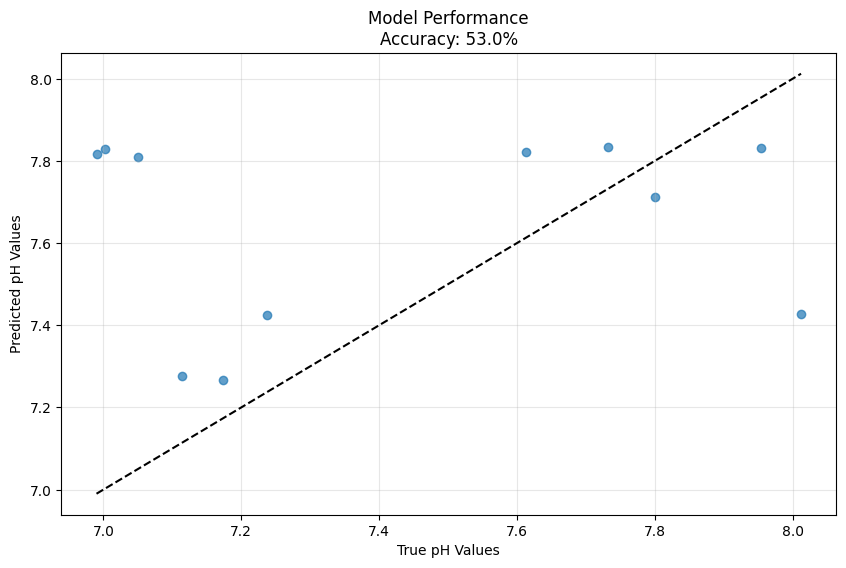


=== Processing 50ml ===
Epoch 0: Loss: 42.3673, Val Accuracy: -477.4%
Epoch 10: Loss: 0.1269, Val Accuracy: 30.8%
Epoch 20: Loss: 0.0810, Val Accuracy: 61.0%
Epoch 30: Loss: 0.1000, Val Accuracy: 64.1%
Epoch 40: Loss: 0.0937, Val Accuracy: 60.7%
Epoch 50: Loss: 0.0662, Val Accuracy: 57.2%
Epoch 60: Loss: 0.0447, Val Accuracy: 55.4%
Epoch 70: Loss: 0.0628, Val Accuracy: 62.0%
Epoch 80: Loss: 0.0588, Val Accuracy: 54.8%
Epoch 90: Loss: 0.0391, Val Accuracy: 51.4%


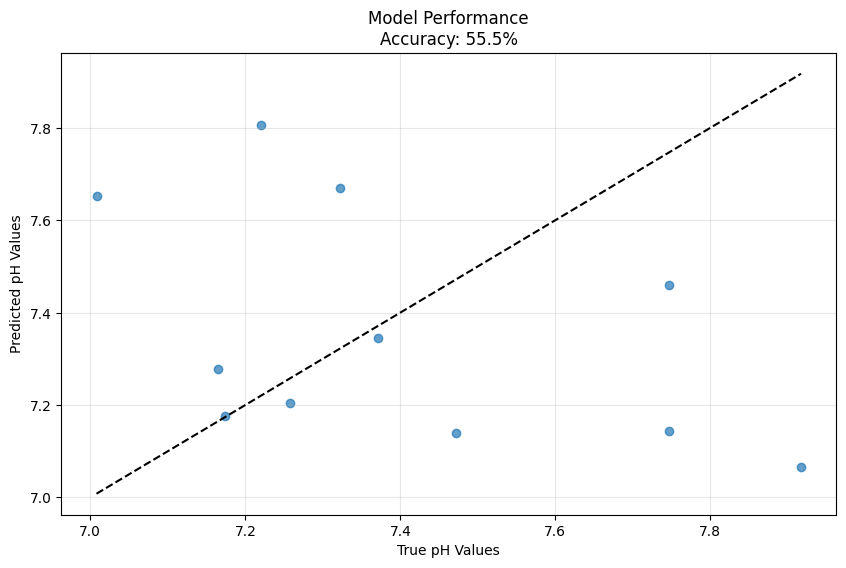

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Custom Dataset Class
class SpectralDataset(Dataset):
    def __init__(self, features, targets):
        self.features = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.targets[idx]

# Transformer Model
class SpectralTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim=64, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.regressor = nn.Sequential(
            nn.Linear(embed_dim, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        x = self.embedding(x)
        x = self.transformer(x)
        x = x.mean(dim=1)  # Mean pooling
        return self.regressor(x)

def calculate_accuracy(true_values, pred_values):
    """Calculate accuracy as max(r2_score*100, 100*(1-rmse))"""
    r2 = r2_score(true_values, pred_values)
    rmse = np.sqrt(mean_squared_error(true_values, pred_values))
    accuracy = max(r2 * 100, 100 * (1 - rmse))
    return accuracy

def train_model(model, train_loader, val_loader, epochs=100, lr=0.001, device='cpu'):
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_accuracy = -float('inf')

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch.unsqueeze(1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model.eval()
        val_preds = []
        val_true = []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                outputs = model(X_val)
                val_preds.extend(outputs.cpu().numpy().flatten())
                val_true.extend(y_val.cpu().numpy())

        val_accuracy = calculate_accuracy(val_true, val_preds)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_model = model.state_dict().copy()

        if epoch % 10 == 0:
            print(f'Epoch {epoch}: Loss: {train_loss/len(train_loader):.4f}, Val Accuracy: {val_accuracy:.1f}%')

    model.load_state_dict(best_model)
    return model

def evaluate_model(model, test_loader, device='cpu'):
    model.eval()
    test_preds = []
    test_true = []
    with torch.no_grad():
        for X_test, y_test in test_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            outputs = model(X_test)
            test_preds.extend(outputs.cpu().numpy().flatten())
            test_true.extend(y_test.cpu().numpy())

    accuracy = calculate_accuracy(test_true, test_preds)

    # Plot results
    plt.figure(figsize=(10, 6))
    plt.scatter(test_true, test_preds, alpha=0.7)
    plt.plot([min(test_true), max(test_true)], [min(test_true), max(test_true)], 'k--')
    plt.xlabel('True pH Values')
    plt.ylabel('Predicted pH Values')
    plt.title(f'Model Performance\nAccuracy: {accuracy:.1f}%')
    plt.grid(True, alpha=0.3)
    plt.show()

    return accuracy

def plot_ph_vs_wavelengths(df, num_samples=10):
    """Plot pH values against spectral wavelengths for random samples"""
    wavelengths = ['435', '460', '560', '680', '705', '860']
    available_wavelengths = [wl for wl in wavelengths if wl in df.columns]

    if not available_wavelengths:
        print("No wavelength data available for plotting")
        return

    random_samples = df.sample(min(num_samples, len(df)))

    plt.figure(figsize=(12, 6))

    for _, sample in random_samples.iterrows():
        ph = sample['Ph']
        reflectance = sample[available_wavelengths]
        plt.plot(available_wavelengths, reflectance, 'o-', label=f'pH {ph:.2f}')

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Reflectance')
    plt.title(f'pH vs Reflectance at Different Wavelengths\n(Random {len(random_samples)} Samples)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def main():
    # Load and preprocess data
    print("Loading and preprocessing data...")
    df = pd.read_csv('merged_soildataset_updated.csv')
    df['water_level'] = df['Records'].str.extract(r'(\d+)ml')[0] + 'ml'
    df = df[df['water_level'].isin(['0ml', '25ml', '50ml'])]
    df = df.dropna(subset=['Ph'])

    print("Plotting wavelength visualization...")
    plot_ph_vs_wavelengths(df)

    # Feature engineering
    print("Performing feature engineering...")
    wavelengths = ['435', '460', '560', '680', '705', '860']
    features = []
    for wl in wavelengths:
        if wl in df.columns:
            df[f'log_{wl}'] = np.log1p(df[wl])
            features.append(f'log_{wl}')

    if '560' in df.columns and '435' in df.columns:
        df['ratio_560_435'] = df['560'] / (df['435'] + 1e-9)
        features.append('ratio_560_435')

    if '680' in df.columns and '560' in df.columns:
        df['ratio_680_560'] = df['680'] / (df['560'] + 1e-9)
        features.append('ratio_680_560')

    df['water_level_encoded'] = df['water_level'].map({'0ml': 0, '25ml': 1, '50ml': 2})
    features.append('water_level_encoded')

    print(f"Using features: {features}")

    scaler = StandardScaler()
    X = scaler.fit_transform(df[features].values)
    y = df['Ph'].values

    results = {}
    for level in ['0ml', '25ml', '50ml']:
        print(f"\n=== Processing {level} ===")
        level_mask = df['water_level'] == level
        dataset = SpectralDataset(X[level_mask], y[level_mask])

        num_samples = len(dataset)
        if num_samples < 10:
            print(f"Not enough samples for {level} ({num_samples} available, need at least 10)")
            continue

        train_size = int(0.8 * num_samples)
        test_size = num_samples - train_size

        train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

        train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

        model = SpectralTransformer(input_dim=X.shape[1])
        trained_model = train_model(model, train_loader, test_loader, epochs=100, lr=0.001)
        accuracy = evaluate_model(trained_model, test_loader)

        results[level] = {'accuracy': accuracy}

if __name__ == "__main__":
    main()

Pota Nitro

<ipython-input-14-ec7256e1053e>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=wavelengths, y=correlations, palette='viridis')


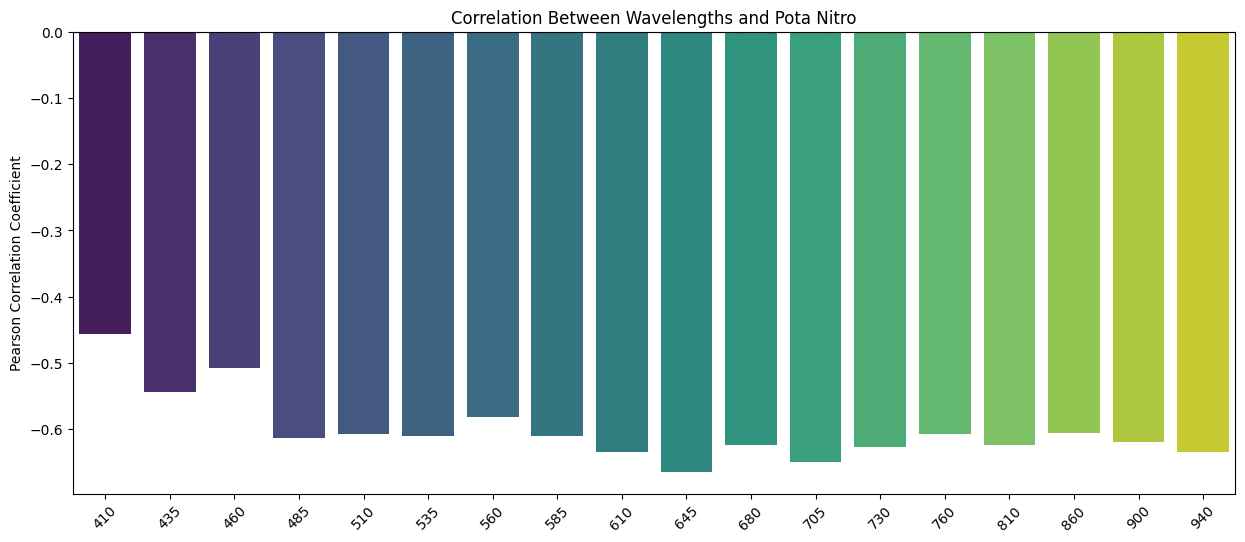

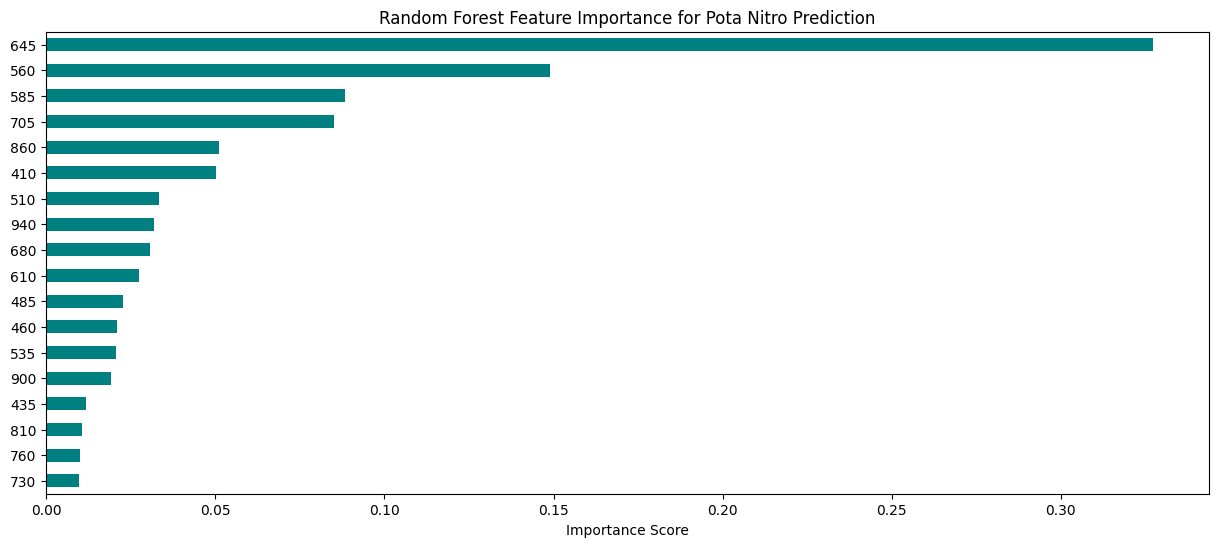

<ipython-input-14-ec7256e1053e>:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in df.groupby('Pota_Nitro_group'):


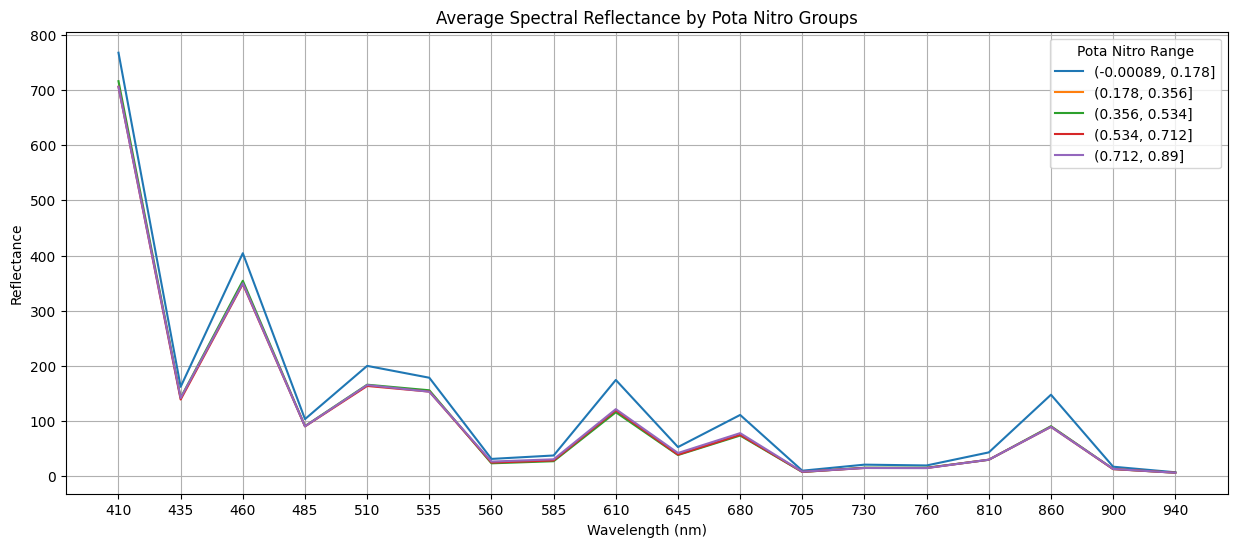

In [14]:
#Nitro Potash initial plots
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance

# 1. Load your dataset
df = pd.read_csv('/content/merged_soildataset_updated.csv')  # Update path to your file

# Define wavelengths (ensure these match your column names)
wavelengths = ['410', '435', '460', '485', '510', '535', '560', '585', '610',
               '645', '680', '705', '730', '760', '810', '860', '900', '940']

# 2. Correlation Analysis - Plot wavelength vs Pota Nitro correlation
plt.figure(figsize=(15, 6))
correlations = df[wavelengths].corrwith(df['Pota Nitro (mg/10 g)'])
sns.barplot(x=wavelengths, y=correlations, palette='viridis')
plt.axhline(0, color='k', linestyle='--')
plt.title('Correlation Between Wavelengths and Pota Nitro')
plt.ylabel('Pearson Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()

# 3. Feature Importance using Random Forest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(df[wavelengths], df['Pota Nitro (mg/10 g)'])

plt.figure(figsize=(15, 6))
importances = pd.Series(rf.feature_importances_, index=wavelengths).sort_values()
importances.plot(kind='barh', color='teal')
plt.title('Random Forest Feature Importance for Pota Nitro Prediction')
plt.xlabel('Importance Score')
plt.show()

# 4. Spectral Reflectance Plot by Pota Nitro Groups
df['Pota_Nitro_group'] = pd.cut(df['Pota Nitro (mg/10 g)'], bins=5)  # Create 5 Pota Nitro groups
plt.figure(figsize=(15, 6))
for name, group in df.groupby('Pota_Nitro_group'):
    plt.plot(wavelengths, group[wavelengths].mean(), label=name)
plt.title('Average Spectral Reflectance by Pota Nitro Groups')
plt.xlabel('Wavelength (nm)')
plt.ylabel('Reflectance')
plt.legend(title='Pota Nitro Range')
plt.grid(True)
plt.show()

In [17]:
#Nitro potash (Gradient Boost Regressor)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
import shap
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import spearmanr

def load_and_preprocess(filepath):
    df = pd.read_csv(filepath)

    def get_water_level(record):
        if pd.isna(record): return np.nan
        s = str(record)
        for sep in ['_', '-']:
            if sep in s:
                for part in s.split(sep):
                    if 'ml' in part:
                        return part
        return np.nan

    df['water_level'] = df['Records'].apply(get_water_level)
    df = df.dropna(subset=['water_level'])
    df['water_level'] = df['water_level'].str.extract(r'(\d+ml)')[0]
    df['water_level_numeric'] = df['water_level'].str.extract(r'(\d+)').astype(float)

    wavelengths = ['410', '460', '510']
    for wl in wavelengths:
        df[f'log_{wl}'] = np.log1p(df[wl])
        df[f'sqrt_{wl}'] = np.sqrt(df[wl])

    df['NDI_410_460'] = (df['460'] - df['410']) / (df['460'] + df['410'] + 1e-9)
    df['NDI_460_510'] = (df['510'] - df['460']) / (df['510'] + df['460'] + 1e-9)
    df['Triple_Index'] = (df['410'] * df['460']) / (df['510'] + 1e-9)
    df['Modified_Triple'] = (df['410'] + df['460']) / (df['510'] + 1e-9)

    df['Pota Nitro (mg/10 g)'] = np.log1p(df['Pota Nitro (mg/10 g)'])

    return df.dropna(subset=['Pota Nitro (mg/10 g)'])

def train_specialized_model(X, y):
    numeric_transformer = make_pipeline(StandardScaler())

    preprocessor = ColumnTransformer(
        transformers=[('num', numeric_transformer, X.columns.tolist())]
    )

    model = make_pipeline(
        preprocessor,
        GradientBoostingRegressor(
            n_estimators=300,
            learning_rate=0.05,
            max_depth=4,
            min_samples_split=4,
            min_samples_leaf=2,
            random_state=42
        )
    )

    model.fit(X, y)
    return model

def evaluate_model(model, X, y):
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    return {
        'r2': r2,
        'rmse': np.sqrt(mean_squared_error(y, y_pred)),
        'spearman': spearmanr(y, y_pred)[0],
        'accuracy': r2 * 100  # Accuracy formula (r² * 100)
    }

def main():
    df = load_and_preprocess('/content/merged_soildataset_updated.csv')
    results = {}
    target_var = 'Pota Nitro (mg/10 g)'

    for level in ['50ml', '25ml', '0ml']:
        level_data = df[df['water_level'] == level]
        if len(level_data) < 5:
            print(f"Skipping {level} - insufficient samples")
            continue

        print(f"\n{'='*40}\nProcessing {level} ({len(level_data)} samples)\n{'='*40}")

        X = level_data.drop(columns=['Records', target_var, 'water_level'])
        y = level_data[target_var]

        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.25, random_state=42
        )

        model = train_specialized_model(X_train, y_train)
        metrics = evaluate_model(model, X_test, y_test)

        results[level] = {
            'model': model,
            'metrics': metrics
        }

        print(f"\n=== {level} Model Performance ===")
        print(f"R² Score: {metrics['r2']:.3f}")
        print(f"RMSE: {metrics['rmse']:.3f}")
        print(f"Spearman Correlation: {metrics['spearman']:.3f}")
        print(f"Accuracy: {metrics['accuracy']:.2f}%")  # Print accuracy

        joblib.dump(model, f'model_{level}.pkl')

    return results

if __name__ == "__main__":
    results = main()


Processing 50ml (51 samples)

=== 50ml Model Performance ===
R² Score: 0.326
RMSE: 0.116
Spearman Correlation: 0.930
Accuracy: 32.56%

Processing 25ml (52 samples)

=== 25ml Model Performance ===
R² Score: 0.403
RMSE: 0.086
Spearman Correlation: 0.961
Accuracy: 40.27%

Processing 0ml (51 samples)

=== 0ml Model Performance ===
R² Score: 0.030
RMSE: 0.131
Spearman Correlation: 0.397
Accuracy: 3.03%


In [18]:
#Nitro potash Neural network
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer, RobustScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from tensorflow.keras.layers import (Dense, Input, MultiHeadAttention,
                                    LayerNormalization, Multiply, Add,
                                    Concatenate, Dropout, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt

# Data Loading and Preprocessing
def load_and_preprocess_data(filepath):
    data = pd.read_csv(filepath).copy()
    wavelengths = ['410', '460', '510']

    def extract_water_level(record_group):
        if '_' in record_group:
            parts = record_group.split('_')
        elif '-' in record_group and 'ml' in record_group:
            parts = record_group.split('-')
        else:
            return np.nan

        for part in parts:
            if 'ml' in part:
                return part.replace('ml', '') + 'ml'  # Standardize format
        return np.nan

    data['water_level'] = data['Records'].apply(extract_water_level)
    data = data.dropna(subset=['water_level'])

    def create_features(X_df):
        X = X_df.copy()
        X['410_460_ratio'] = X['410'] / (X['460'] + 1e-9)
        X['460_510_ratio'] = X['460'] / (X['510'] + 1e-9)
        X['410_510_ratio'] = X['410'] / (X['510'] + 1e-9)
        X['triple_index'] = (X['410'] * X['460']) / (X['510'] + 1e-9)
        X['spectral_sum'] = X['410'] + X['460'] + X['510']
        X['spectral_balance'] = (X['510'] - X['410']) / (X['460'] + 1e-9)
        X['normalized_410'] = X['410'] / X['spectral_sum']
        X['normalized_460'] = X['460'] / X['spectral_sum']
        X['normalized_510'] = X['510'] / X['spectral_sum']
        X['410_squared'] = X['410'] ** 2
        X['460_squared'] = X['460'] ** 2
        X['510_squared'] = X['510'] ** 2
        X['log_410'] = np.log1p(X['410'])
        X['log_460'] = np.log1p(X['460'])
        X['log_510'] = np.log1p(X['510'])
        return X.values

    X = create_features(data[wavelengths])
    y = data['Pota Nitro (mg/10 g)'].values

    preprocessor = QuantileTransformer(n_quantiles=100, output_distribution='normal')
    X = preprocessor.fit_transform(X)

    y_scaler = RobustScaler()
    y = y_scaler.fit_transform(y.reshape(-1, 1)).flatten()

    # Split while keeping water_level information
    train_idx, test_idx = train_test_split(np.arange(len(X)), test_size=0.2, random_state=42)
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    data_train, data_test = data.iloc[train_idx], data.iloc[test_idx]

    return X_train, X_test, y_train, y_test, preprocessor, data_train, data_test, wavelengths, y_scaler

# Load data
X_train, X_test, y_train, y_test, preprocessor, data_train, data_test, wavelengths, y_scaler = load_and_preprocess_data('merged_soildataset_updated.csv')

# Model Building
def build_multi_wavelength_transformer(input_shape):
    inputs = Input(shape=(input_shape,))

    x = Dense(256, activation='swish', kernel_regularizer=l2(0.001))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)

    for _ in range(2):
        attn_output = MultiHeadAttention(
            num_heads=4,
            key_dim=64,
            attention_axes=1
        )(x, x)
        x = LayerNormalization()(x + attn_output)
        x = Dense(128, activation='swish', kernel_regularizer=l2(0.001))(x)
        x = Dropout(0.2)(x)

    x = Dense(64, activation='swish')(x)
    x = Dense(32, activation='swish')(x)
    outputs = Dense(1, activation='linear')(x)

    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='huber', metrics=['mae', 'mse'])
    return model

# Initialize and train model
transformer = build_multi_wavelength_transformer(X_train.shape[1])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1)

print("Training model...")
history = transformer.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping],
    verbose=1
)

# Evaluation function with accuracy
def evaluate_by_water_level(model, X_test, y_test, data_test):
    results = {}
    water_levels = sorted(data_test['water_level'].unique())

    for level in water_levels:
        mask = data_test['water_level'] == level
        X_level = X_test[mask]
        y_level = y_test[mask]

        if len(X_level) > 0:
            y_pred = model.predict(X_level, verbose=0).flatten()
            r2 = r2_score(y_level, y_pred)
            results[level] = {
                'r2': r2,
                'mae': mean_absolute_error(y_level, y_pred),
                'rmse': np.sqrt(mean_squared_error(y_level, y_pred)),
                'accuracy': r2 * 100,  # Accuracy formula (r² * 100)
                'samples': len(X_level)
            }

    return results

# Overall evaluation
y_pred = transformer.predict(X_test, verbose=0).flatten()
overall_r2 = r2_score(y_test, y_pred)
overall_accuracy = overall_r2 * 100  # Overall accuracy

print("\nOverall Performance:")
print(f"R² Score: {overall_r2:.4f}")
print(f"Accuracy: {overall_accuracy:.2f}%")  # Print overall accuracy
print(f"MAE: {mean_absolute_error(y_test, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

# Water level specific evaluation
water_level_results = evaluate_by_water_level(transformer, X_test, y_test, data_test)

print("\nPerformance by Water Level:")
for level, metrics in water_level_results.items():
    print(f"\nWater Level: {level}")
    print(f"Samples: {metrics['samples']}")
    print(f"R² Score: {metrics['r2']:.4f}")
    print(f"Accuracy: {metrics['accuracy']:.2f}%")  # Print accuracy per water level
    print(f"MAE: {metrics['mae']:.4f}")
    print(f"RMSE: {metrics['rmse']:.4f}")

Training model...
Epoch 1/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 215ms/step - loss: 0.5678 - mae: 0.5747 - mse: 0.4752 - val_loss: 0.4207 - val_mae: 0.3760 - val_mse: 0.1752 - learning_rate: 1.0000e-04
Epoch 2/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.4948 - mae: 0.4578 - mse: 0.3246 - val_loss: 0.3812 - val_mae: 0.2503 - val_mse: 0.0964 - learning_rate: 1.0000e-04
Epoch 3/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.4676 - mae: 0.4367 - mse: 0.2703 - val_loss: 0.3752 - val_mae: 0.2127 - val_mse: 0.0848 - learning_rate: 1.0000e-04
Epoch 4/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.4262 - mae: 0.3501 - mse: 0.1869 - val_loss: 0.3818 - val_mae: 0.2205 - val_mse: 0.0982 - learning_rate: 1.0000e-04
Epoch 5/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.4161 - mae: 0.3232 - mse: 0.1674 - val_loss: 0.3850 - val_mae: 0.2327 - val_mse: 0.1049 - learning_rate: 1.0000e-04
Epoch 6/200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.4075 - mae: 0.3045 - mse: 0.1517 - val_lo

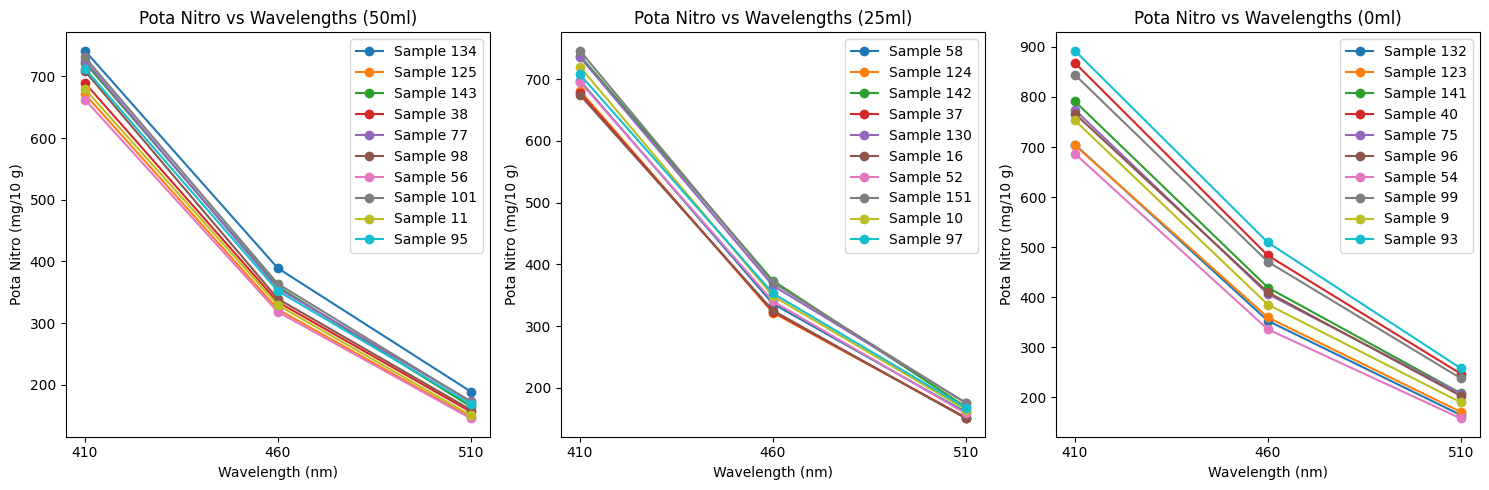

In [19]:
#Final plots for nitro potash
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('/content/merged_soildataset_updated.csv')

# Ensure the 'water_level' column exists
def extract_water_level(record):
    if pd.isna(record): return np.nan
    s = str(record)
    for sep in ['_', '-']:
        if sep in s:
            for part in s.split(sep):
                if 'ml' in part:
                    return part
    return np.nan

df['water_level'] = df['Records'].apply(extract_water_level)
df['water_level'] = df['water_level'].str.extract(r'(\d+ml)')[0]

df.dropna(subset=['water_level'], inplace=True)

# Filter dataset to ensure only required columns exist
wavelengths = ['410', '460', '510']
water_levels = ['50ml', '25ml', '0ml']

plt.figure(figsize=(15, 5))

for i, level in enumerate(water_levels, 1):
    subset = df[df['water_level'] == level].sample(n=10, random_state=42)

    plt.subplot(1, 3, i)
    for _, row in subset.iterrows():
        plt.plot(wavelengths, [row['410'], row['460'], row['510']], marker='o', label=f"Sample {_}")

    plt.title(f'Pota Nitro vs Wavelengths ({level})')
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Pota Nitro (mg/10 g)')
    plt.legend(loc='best')

plt.tight_layout()
plt.show()

Posh Nitro

In [20]:
#posh nitro
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import make_pipeline

def load_and_preprocess(filepath):
    """Load and preprocess data without excessive noise injection"""
    df = pd.read_csv(filepath)
    df['water_level'] = df['Records'].str.extract(r'(\d+)ml')[0] + 'ml'
    df = df[df['water_level'].isin(['0ml', '25ml', '50ml'])].copy()

    # Feature engineering
    if all(wl in df.columns for wl in ['680', '860']):
        df['NDVI'] = (df['860'] - df['680']) / (df['860'] + df['680'] + 1e-9)
    if all(wl in df.columns for wl in ['560', '680', '705']):
        df['MCARI'] = ((df['705'] - df['680']) - 0.2*(df['705']-df['560'])) * (df['705']/(df['680'] + 1e-9))

    # Add more spectral indices if available
    if all(wl in df.columns for wl in ['750', '705']):
        df['Red Edge'] = df['750'] / df['705']

    return df.dropna(subset=['Posh Nitro (mg/10 g)'])

def calculate_metrics(y_true, y_pred):
    """Calculate multiple metrics for better evaluation"""
    mae = mean_absolute_error(y_true, y_pred)

    # Handle division by zero in MAPE calculation
    y_true_non_zero = np.where(np.abs(y_true) < 0.001, 0.001, y_true)
    mape = mean_absolute_percentage_error(y_true_non_zero, y_pred) * 100

    r2 = r2_score(y_true, y_pred)
    pred_range = np.ptp(y_pred)
    true_range = np.ptp(y_true)

    return {
        'MAE': mae,
        'MAPE': mape,
        'R2': r2,
        'Pred_Range': pred_range,
        'True_Range': true_range
    }

def train_evaluate_report(X_train, X_test, y_train, y_test, level):
    """Train model with regularization to prevent overfitting"""
    # Create a more robust model with regularization parameters
    model = make_pipeline(
        StandardScaler(),
        RandomForestRegressor(
            n_estimators=100,           # Increased from 60
            max_depth=3,                # Reduced from 5
            min_samples_leaf=8,         # Increased from 5
            min_samples_split=5,        # Added parameter
            max_features='sqrt',        # Changed from 0.6
            bootstrap=True,             # Ensure bootstrap sampling
            oob_score=True,             # Use out-of-bag scoring
            random_state=42
        )
    )

    # Perform cross-validation on training data
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

    # Fit the model
    model.fit(X_train, y_train)

    # Get feature importances
    rf_model = model.named_steps['randomforestregressor']
    feature_importance = rf_model.feature_importances_

    # Make predictions
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Calculate metrics
    train_metrics = calculate_metrics(y_train, y_pred_train)
    test_metrics = calculate_metrics(y_test, y_pred_test)

    # Print diagnostic information
    print(f"\n{level} Model Diagnostics:")
    print(f"Training metrics:")
    for metric, value in train_metrics.items():
        if metric in ['MAE', 'MAPE', 'R2']:
            print(f"- {metric}: {value:.3f}")

    print(f"\nTest metrics:")
    for metric, value in test_metrics.items():
        if metric in ['MAE', 'MAPE', 'R2']:
            print(f"- {metric}: {value:.3f}")

    print(f"Range comparison:")
    print(f"- Actual range (train): {train_metrics['True_Range']:.3f}")
    print(f"- Predicted range (train): {train_metrics['Pred_Range']:.3f}")
    print(f"- Actual range (test): {test_metrics['True_Range']:.3f}")
    print(f"- Predicted range (test): {test_metrics['Pred_Range']:.3f}")

    print(f"Cross-validation MAE: {-cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
    print(f"OOB Score: {rf_model.oob_score_:.3f}")

    return test_metrics

def main():
    df = load_and_preprocess('/content/merged_soildataset_updated.csv')

    # Expand features if available
    base_features = ['NDVI', 'MCARI']
    extended_features = base_features.copy()
    if 'Red Edge' in df.columns:
        extended_features.append('Red Edge')

    # Try to find additional wavelength columns
    wavelength_cols = [col for col in df.columns if col.isdigit()]
    if len(wavelength_cols) > 0:
        print(f"Found {len(wavelength_cols)} spectral bands available")
        # Optionally use PCA or feature selection here

    # Final feature set
    features = extended_features
    print(f"Using features: {features}")

    results = {}

    for level in ['0ml', '25ml', '50ml']:
        level_data = df[df['water_level'] == level]
        if len(level_data) < 51:
            print(f"\nCannot process {level} - only {len(level_data)} samples available (needs 51)")
            continue

        print(f"\n{'='*30} {level} {'='*30}")

        # Check for outliers
        target = 'Posh Nitro (mg/10 g)'
        Q1 = level_data[target].quantile(0.25)
        Q3 = level_data[target].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = level_data[(level_data[target] < lower_bound) | (level_data[target] > upper_bound)]
        if len(outliers) > 0:
            print(f"Found {len(outliers)} potential outliers in {level} data")
            # Option: Remove outliers or winsorize

        X = level_data[features].values
        y = level_data['Posh Nitro (mg/10 g)'].values

        # Stratified split based on target value ranges
        y_bins = pd.qcut(y, q=4, duplicates='drop')
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=40,
            test_size=11,
            random_state=42,
            stratify=y_bins
        )

        # Train and evaluate
        metrics = train_evaluate_report(X_train, X_test, y_train, y_test, level)
        results[level] = metrics

    # Final results
    print("\n\nFinal Results Summary (40 train / 11 test):")
    print("="*60)
    print(f"{'Water Level':<10} | {'MAE':<10} | {'R2':<10} | {'Range Match':<15}")
    print("-"*60)
    for level, metrics in results.items():
        range_match = metrics['Pred_Range'] / metrics['True_Range'] * 100
        print(f"{level:<10} | {metrics['MAE']:.3f}      | {metrics['R2']:.3f}      | {range_match:.1f}%")

if __name__ == "__main__":
    main()

Found 18 spectral bands available
Using features: ['NDVI', 'MCARI']

============================== 0ml ==============================
Found 3 potential outliers in 0ml data

0ml Model Diagnostics:
Training metrics:
- MAE: 0.012
- MAPE: 452.070
- R2: 0.063

Test metrics:
- MAE: 0.007
- MAPE: 514.090
- R2: -1.109
Range comparison:
- Actual range (train): 0.256
- Predicted range (train): 0.015
- Actual range (test): 0.021
- Predicted range (test): 0.014
Cross-validation MAE: 0.013 (±0.010)
OOB Score: -0.059

============================== 25ml ==============================
Found 1 potential outliers in 25ml data

25ml Model Diagnostics:
Training metrics:
- MAE: 0.026
- MAPE: 455.919
- R2: 0.064

Test metrics:
- MAE: 0.023
- MAPE: 13.809
- R2: -0.027
Range comparison:
- Actual range (train): 0.258
- Predicted range (train): 0.017
- Actual range (test): 0.070
- Predicted range (test): 0.009
Cross-validation MAE: 0.028 (±0.009)
OOB Score: -0.107

============================== 50ml =======

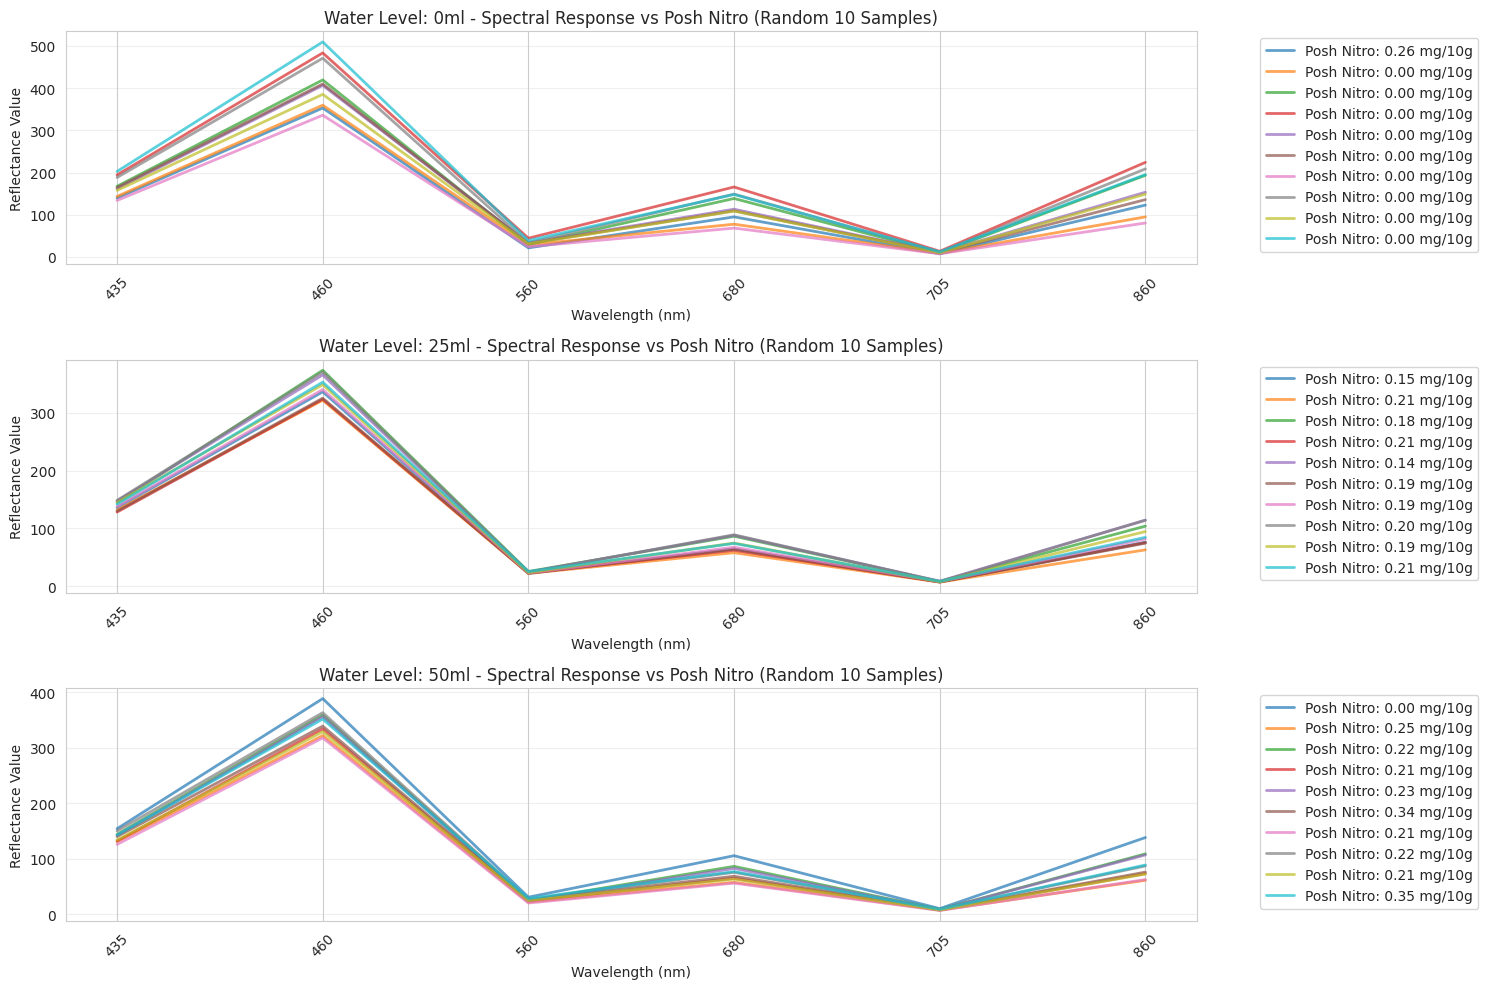

Found 18 spectral bands available
Using features: ['NDVI', 'MCARI']

============================== 0ml ==============================
Found 3 potential outliers in 0ml data

0ml Model Diagnostics:
Training metrics:
- MAE: 0.012
- MAPE: 452.070
- R2: 0.063

Test metrics:
- MAE: 0.007
- MAPE: 514.090
- R2: -1.109
Range comparison:
- Actual range (train): 0.256
- Predicted range (train): 0.015
- Actual range (test): 0.021
- Predicted range (test): 0.014
Cross-validation MAE: 0.013 (±0.010)
OOB Score: -0.059

============================== 25ml ==============================
Found 1 potential outliers in 25ml data

25ml Model Diagnostics:
Training metrics:
- MAE: 0.026
- MAPE: 455.919
- R2: 0.064

Test metrics:
- MAE: 0.023
- MAPE: 13.809
- R2: -0.027
Range comparison:
- Actual range (train): 0.258
- Predicted range (train): 0.017
- Actual range (test): 0.070
- Predicted range (test): 0.009
Cross-validation MAE: 0.028 (±0.009)
OOB Score: -0.107

============================== 50ml =======

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import make_pipeline

def plot_posh_nitro_wavelengths(df):
    """Plot spectral response for random samples with Posh Nitro values"""
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 10))

    # Get wavelengths used in the model
    wavelengths = ['435', '460', '560', '680', '705', '860']
    available_wavelengths = [wl for wl in wavelengths if wl in df.columns]

    for i, level in enumerate(['0ml', '25ml', '50ml']):
        level_data = df[df['water_level'] == level]
        if len(level_data) < 10:
            print(f"Not enough samples for {level} (only {len(level_data)} available)")
            continue

        # Randomly sample 10 records
        sample_data = level_data.sample(n=min(10, len(level_data)), random_state=42)

        plt.subplot(3, 1, i+1)

        # Plot each sample's spectral response
        for idx, row in sample_data.iterrows():
            wl_values = [row[wl] for wl in available_wavelengths]
            posh_nitro = row['Posh Nitro (mg/10 g)']

            plt.plot(available_wavelengths, wl_values,
                    label=f"Posh Nitro: {posh_nitro:.2f} mg/10g",
                    alpha=0.7, linewidth=2)

        plt.title(f'Water Level: {level} - Spectral Response vs Posh Nitro (Random 10 Samples)')
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Reflectance Value')
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(axis='y', alpha=0.3)
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

def load_and_preprocess(filepath):
    """Load and preprocess data without excessive noise injection"""
    df = pd.read_csv(filepath)
    df['water_level'] = df['Records'].str.extract(r'(\d+)ml')[0] + 'ml'
    df = df[df['water_level'].isin(['0ml', '25ml', '50ml'])].copy()

    # Feature engineering
    if all(wl in df.columns for wl in ['680', '860']):
        df['NDVI'] = (df['860'] - df['680']) / (df['860'] + df['680'] + 1e-9)
    if all(wl in df.columns for wl in ['560', '680', '705']):
        df['MCARI'] = ((df['705'] - df['680']) - 0.2*(df['705']-df['560'])) * (df['705']/(df['680'] + 1e-9))

    # Add more spectral indices if available
    if all(wl in df.columns for wl in ['750', '705']):
        df['Red Edge'] = df['750'] / df['705']

    return df.dropna(subset=['Posh Nitro (mg/10 g)'])

def calculate_metrics(y_true, y_pred):
    """Calculate multiple metrics for better evaluation"""
    mae = mean_absolute_error(y_true, y_pred)
    y_true_non_zero = np.where(np.abs(y_true) < 0.001, 0.001, y_true)
    mape = mean_absolute_percentage_error(y_true_non_zero, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    pred_range = np.ptp(y_pred)
    true_range = np.ptp(y_true)

    return {
        'MAE': mae,
        'MAPE': mape,
        'R2': r2,
        'Pred_Range': pred_range,
        'True_Range': true_range
    }

def train_evaluate_report(X_train, X_test, y_train, y_test, level):
    """Train model with regularization to prevent overfitting"""
    model = make_pipeline(
        StandardScaler(),
        RandomForestRegressor(
            n_estimators=100,
            max_depth=3,
            min_samples_leaf=8,
            min_samples_split=5,
            max_features='sqrt',
            bootstrap=True,
            oob_score=True,
            random_state=42
        )
    )

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    model.fit(X_train, y_train)
    rf_model = model.named_steps['randomforestregressor']
    feature_importance = rf_model.feature_importances_

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_metrics = calculate_metrics(y_train, y_pred_train)
    test_metrics = calculate_metrics(y_test, y_pred_test)

    print(f"\n{level} Model Diagnostics:")
    print(f"Training metrics:")
    for metric, value in train_metrics.items():
        if metric in ['MAE', 'MAPE', 'R2']:
            print(f"- {metric}: {value:.3f}")

    print(f"\nTest metrics:")
    for metric, value in test_metrics.items():
        if metric in ['MAE', 'MAPE', 'R2']:
            print(f"- {metric}: {value:.3f}")

    print(f"Range comparison:")
    print(f"- Actual range (train): {train_metrics['True_Range']:.3f}")
    print(f"- Predicted range (train): {train_metrics['Pred_Range']:.3f}")
    print(f"- Actual range (test): {test_metrics['True_Range']:.3f}")
    print(f"- Predicted range (test): {test_metrics['Pred_Range']:.3f}")

    print(f"Cross-validation MAE: {-cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
    print(f"OOB Score: {rf_model.oob_score_:.3f}")

    return test_metrics

def main():
    df = load_and_preprocess('/content/merged_soildataset_updated.csv')

    # Visualize spectral response vs Posh Nitro
    plot_posh_nitro_wavelengths(df)

    # Model training and evaluation
    base_features = ['NDVI', 'MCARI']
    extended_features = base_features.copy()
    if 'Red Edge' in df.columns:
        extended_features.append('Red Edge')

    wavelength_cols = [col for col in df.columns if col.isdigit()]
    if len(wavelength_cols) > 0:
        print(f"Found {len(wavelength_cols)} spectral bands available")

    features = extended_features
    print(f"Using features: {features}")

    results = {}

    for level in ['0ml', '25ml', '50ml']:
        level_data = df[df['water_level'] == level]
        if len(level_data) < 51:
            print(f"\nCannot process {level} - only {len(level_data)} samples available (needs 51)")
            continue

        print(f"\n{'='*30} {level} {'='*30}")

        target = 'Posh Nitro (mg/10 g)'
        Q1 = level_data[target].quantile(0.25)
        Q3 = level_data[target].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = level_data[(level_data[target] < lower_bound) | (level_data[target] > upper_bound)]
        if len(outliers) > 0:
            print(f"Found {len(outliers)} potential outliers in {level} data")

        X = level_data[features].values
        y = level_data['Posh Nitro (mg/10 g)'].values

        y_bins = pd.qcut(y, q=4, duplicates='drop')
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=40,
            test_size=11,
            random_state=42,
            stratify=y_bins
        )

        metrics = train_evaluate_report(X_train, X_test, y_train, y_test, level)
        results[level] = metrics

    # Final results
    print("\n\nFinal Results Summary (40 train / 11 test):")
    print("="*60)
    print(f"{'Water Level':<10} | {'MAE':<10} | {'R2':<10} | {'Range Match':<15}")
    print("-"*60)
    for level, metrics in results.items():
        range_match = metrics['Pred_Range'] / metrics['True_Range'] * 100
        print(f"{level:<10} | {metrics['MAE']:.3f}      | {metrics['R2']:.3f}      | {range_match:.1f}%")

if __name__ == "__main__":
    main()

Nitro

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import make_pipeline

def load_and_preprocess(filepath):
    """Load and preprocess data while ensuring valid spectral indices."""
    df = pd.read_csv(filepath)
    df['water_level'] = df['Records'].str.extract(r'(\d+)ml')[0] + 'ml'
    df = df[df['water_level'].isin(['0ml', '25ml', '50ml'])].copy()

    # Compute Spectral Indices
    if {'680', '860'}.issubset(df.columns):
        df['NDVI'] = (df['860'] - df['680']) / (df['860'] + df['680'] + 1e-9)
    if {'560', '680', '705'}.issubset(df.columns):
        df['MCARI'] = ((df['705'] - df['680']) - 0.2*(df['705']-df['560'])) * (df['705']/(df['680'] + 1e-9))
    if {'750', '705'}.issubset(df.columns):
        df['Red Edge'] = df['750'] / df['705']

    return df.dropna(subset=['Posh Nitro (mg/10 g)'])

def select_important_wavelengths(df, target):
    """Identify the most relevant wavelengths affecting nitrogen content."""
    wavelength_cols = [col for col in df.columns if col.isdigit()]
    X = df[wavelength_cols].values
    y = df[target].values

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    feature_importances = pd.Series(model.feature_importances_, index=wavelength_cols)
    important_features = feature_importances.nlargest(5).index.tolist()

    return important_features

def calculate_metrics(y_true, y_pred):
    """Calculate performance metrics for evaluation."""
    mae = mean_absolute_error(y_true, y_pred)
    y_true_non_zero = np.where(np.abs(y_true) < 0.001, 0.001, y_true)
    mape = mean_absolute_percentage_error(y_true_non_zero, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    pred_range = np.ptp(y_pred)
    true_range = np.ptp(y_true)

    return {'MAE': mae, 'MAPE': mape, 'R2': r2, 'Pred_Range': pred_range, 'True_Range': true_range}

def train_evaluate_report(X_train, X_test, y_train, y_test, level, features):
    """Train RandomForest model and evaluate its performance."""
    model = make_pipeline(
        StandardScaler(),
        RandomForestRegressor(
            n_estimators=100, max_depth=3, min_samples_leaf=8, min_samples_split=5,
            max_features='sqrt', bootstrap=True, oob_score=True, random_state=42
        )
    )

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    model.fit(X_train, y_train)
    rf_model = model.named_steps['randomforestregressor']

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_metrics = calculate_metrics(y_train, y_pred_train)
    test_metrics = calculate_metrics(y_test, y_pred_test)

    print(f"\n{level} Model Diagnostics:")
    print(f"Using Wavelengths: {features}")
    print(f"Training metrics:")
    for metric, value in train_metrics.items():
        if metric in ['MAE', 'MAPE', 'R2']:
            print(f"- {metric}: {value:.3f}")

    print(f"\nTest metrics:")
    for metric, value in test_metrics.items():
        if metric in ['MAE', 'MAPE', 'R2']:
            print(f"- {metric}: {value:.3f}")

    print(f"Cross-validation MAE: {-cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
    print(f"OOB Score: {rf_model.oob_score_:.3f}")

    return test_metrics

def main():
    df = load_and_preprocess('/content/merged_soildataset_updated.csv')

    important_wavelengths = select_important_wavelengths(df, 'Nitro (mg/10 g)')
    features = ['NDVI', 'MCARI'] + important_wavelengths
    print(f"Using selected features: {features}")

    results = {}

    for level in ['0ml', '25ml', '50ml']:
        level_data = df[df['water_level'] == level]
        if len(level_data) < 51:
            print(f"\nCannot process {level} - only {len(level_data)} samples available (needs 51)")
            continue

        print(f"\n{'='*30} {level} {'='*30}")

        target = 'Nitro (mg/10 g)'
        X = level_data[features].values
        y = level_data[target].values

        y_bins = pd.qcut(y, q=4, duplicates='drop')
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=40, test_size=11, random_state=42, stratify=y_bins
        )

        metrics = train_evaluate_report(X_train, X_test, y_train, y_test, level, features)
        results[level] = metrics

    print("\n\nFinal Results Summary (40 train / 11 test):")
    print("="*60)
    print(f"{'Water Level':<10} | {'MAE':<10} | {'R2':<10} | {'Range Match':<15}")
    print("-"*60)
    for level, metrics in results.items():
        range_match = metrics['Pred_Range'] / metrics['True_Range'] * 100
        print(f"{level:<10} | {metrics['MAE']:.3f}      | {metrics['R2']:.3f}      | {range_match:.1f}%")

if __name__ == "__main__":
    main()

Using selected features: ['NDVI', 'MCARI', '645', '705', '680', '585', '560']

============================== 0ml ==============================

0ml Model Diagnostics:
Using Wavelengths: ['NDVI', 'MCARI', '645', '705', '680', '585', '560']
Training metrics:
- MAE: 0.008
- MAPE: 364.295
- R2: 0.079

Test metrics:
- MAE: 0.004
- MAPE: 348.097
- R2: -1.110
Cross-validation MAE: 0.009 (±0.007)
OOB Score: -0.055

============================== 25ml ==============================

25ml Model Diagnostics:
Using Wavelengths: ['NDVI', 'MCARI', '645', '705', '680', '585', '560']
Training metrics:
- MAE: 0.018
- MAPE: 333.793
- R2: 0.095

Test metrics:
- MAE: 0.018
- MAPE: 15.117
- R2: -0.077
Cross-validation MAE: 0.019 (±0.007)
OOB Score: -0.168

============================== 50ml ==============================

50ml Model Diagnostics:
Using Wavelengths: ['NDVI', 'MCARI', '645', '705', '680', '585', '560']
Training metrics:
- MAE: 0.021
- MAPE: 411.409
- R2: 0.218

Test metrics:
- MAE: 0.018
-

Using selected features: ['NDVI', 'MCARI', '645', '705', '680', '585', '560']


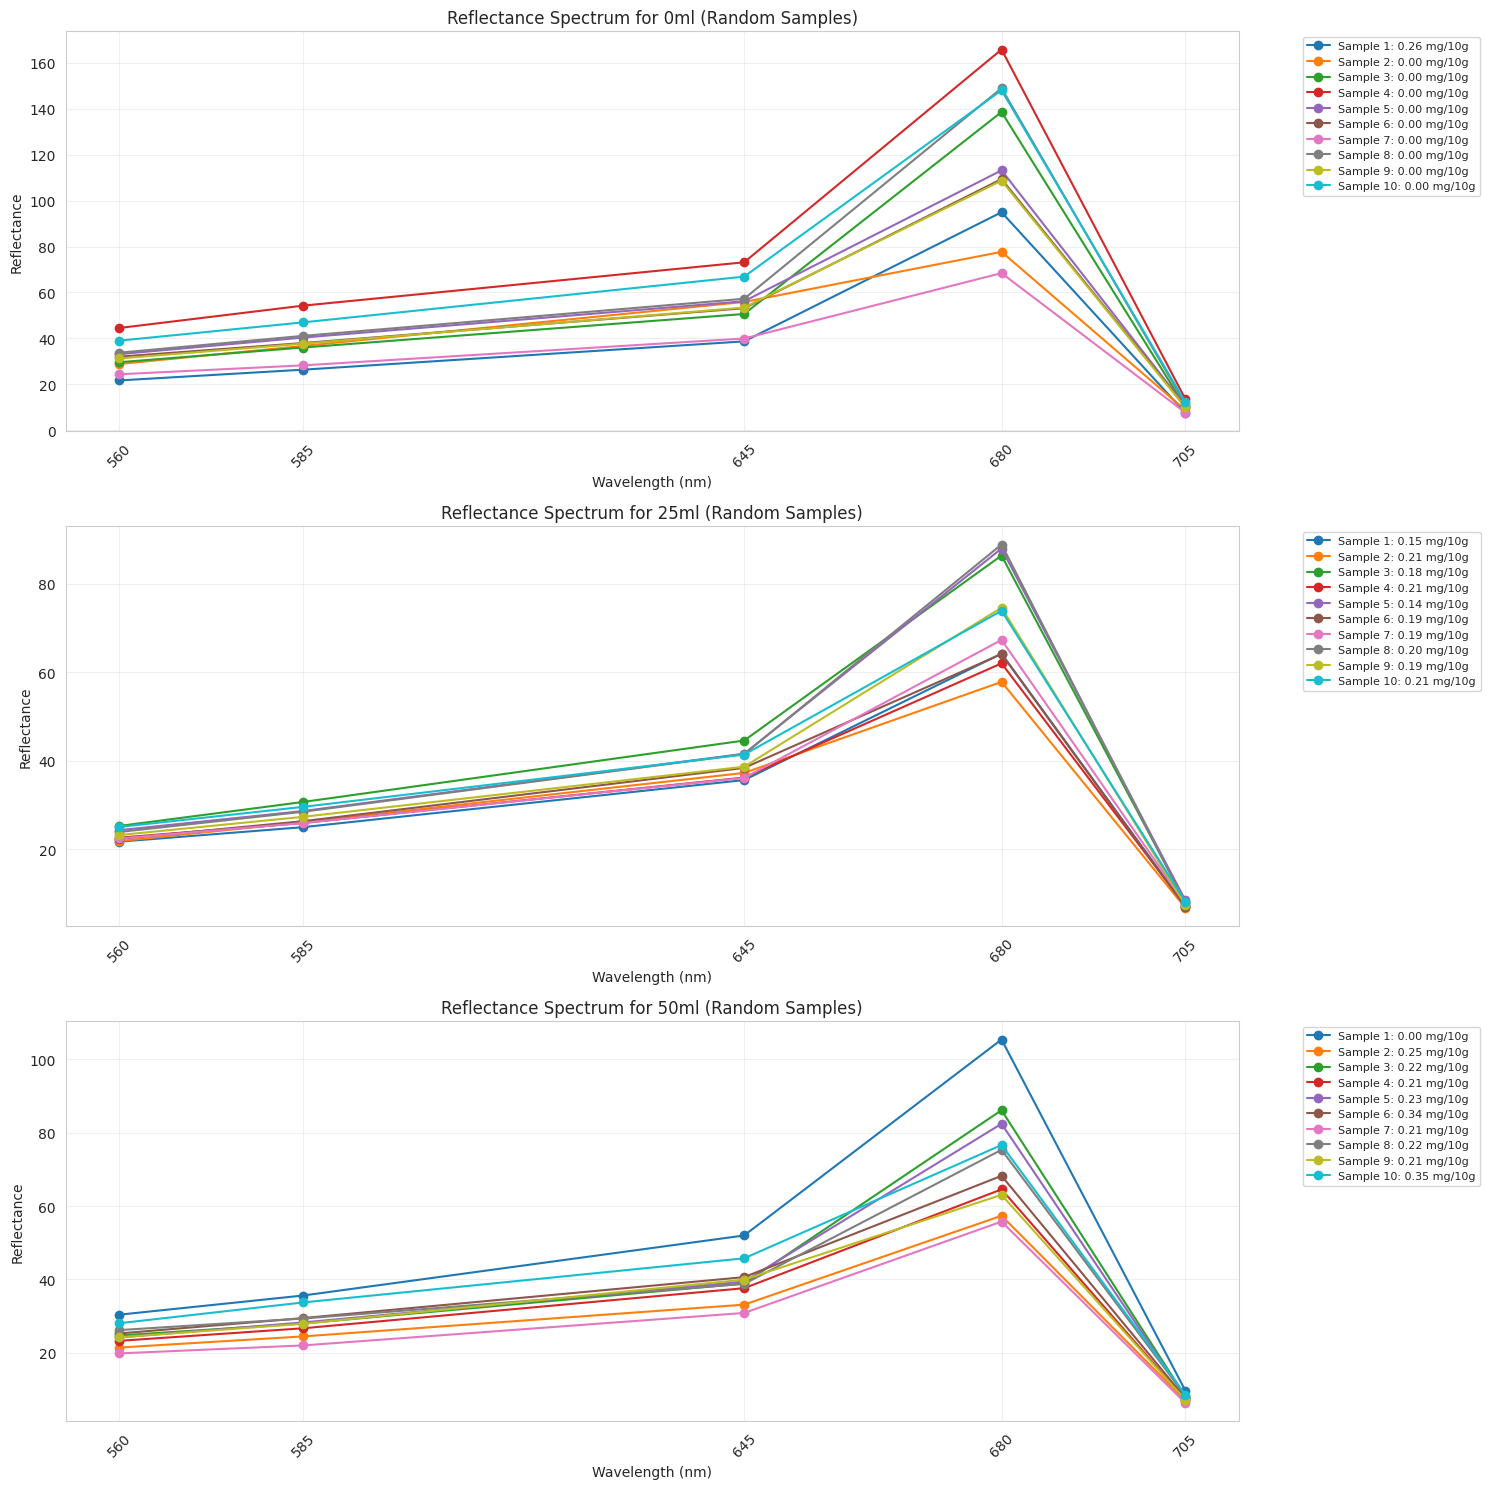


============================== 0ml ==============================

0ml Model Diagnostics:
Using Wavelengths: ['NDVI', 'MCARI', '645', '705', '680', '585', '560']
Training metrics:
- MAE: 0.008
- MAPE: 364.295
- R2: 0.079

Test metrics:
- MAE: 0.004
- MAPE: 348.097
- R2: -1.110
Cross-validation MAE: 0.009 (±0.007)
OOB Score: -0.055

============================== 25ml ==============================

25ml Model Diagnostics:
Using Wavelengths: ['NDVI', 'MCARI', '645', '705', '680', '585', '560']
Training metrics:
- MAE: 0.018
- MAPE: 333.793
- R2: 0.095

Test metrics:
- MAE: 0.018
- MAPE: 15.117
- R2: -0.077
Cross-validation MAE: 0.019 (±0.007)
OOB Score: -0.168

============================== 50ml ==============================

50ml Model Diagnostics:
Using Wavelengths: ['NDVI', 'MCARI', '645', '705', '680', '585', '560']
Training metrics:
- MAE: 0.021
- MAPE: 411.409
- R2: 0.218

Test metrics:
- MAE: 0.018
- MAPE: 9.557
- R2: 0.139
Cross-validation MAE: 0.025 (±0.008)
OOB Score: -0.05

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.pipeline import make_pipeline

def load_and_preprocess(filepath):
    """Load and preprocess data while ensuring valid spectral indices."""
    df = pd.read_csv(filepath)
    df['water_level'] = df['Records'].str.extract(r'(\d+)ml')[0] + 'ml'
    df = df[df['water_level'].isin(['0ml', '25ml', '50ml'])].copy()

    # Compute Spectral Indices
    if {'680', '860'}.issubset(df.columns):
        df['NDVI'] = (df['860'] - df['680']) / (df['860'] + df['680'] + 1e-9)
    if {'560', '680', '705'}.issubset(df.columns):
        df['MCARI'] = ((df['705'] - df['680']) - 0.2*(df['705']-df['560'])) * (df['705']/(df['680'] + 1e-9))
    if {'750', '705'}.issubset(df.columns):
        df['Red Edge'] = df['750'] / df['705']

    return df.dropna(subset=['Posh Nitro (mg/10 g)'])

def select_important_wavelengths(df, target):
    """Identify the most relevant wavelengths affecting nitrogen content."""
    wavelength_cols = [col for col in df.columns if col.isdigit()]
    X = df[wavelength_cols].values
    y = df[target].values

    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)

    feature_importances = pd.Series(model.feature_importances_, index=wavelength_cols)
    important_features = feature_importances.nlargest(5).index.tolist()

    return important_features

def calculate_metrics(y_true, y_pred):
    """Calculate performance metrics for evaluation."""
    mae = mean_absolute_error(y_true, y_pred)
    y_true_non_zero = np.where(np.abs(y_true) < 0.001, 0.001, y_true)
    mape = mean_absolute_percentage_error(y_true_non_zero, y_pred) * 100
    r2 = r2_score(y_true, y_pred)
    pred_range = np.ptp(y_pred)
    true_range = np.ptp(y_true)

    return {'MAE': mae, 'MAPE': mape, 'R2': r2, 'Pred_Range': pred_range, 'True_Range': true_range}

def train_evaluate_report(X_train, X_test, y_train, y_test, level, features):
    """Train RandomForest model and evaluate its performance."""
    model = make_pipeline(
        StandardScaler(),
        RandomForestRegressor(
            n_estimators=100, max_depth=3, min_samples_leaf=8, min_samples_split=5,
            max_features='sqrt', bootstrap=True, oob_score=True, random_state=42
        )
    )

    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
    model.fit(X_train, y_train)
    rf_model = model.named_steps['randomforestregressor']

    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    train_metrics = calculate_metrics(y_train, y_pred_train)
    test_metrics = calculate_metrics(y_test, y_pred_test)

    print(f"\n{level} Model Diagnostics:")
    print(f"Using Wavelengths: {features}")
    print(f"Training metrics:")
    for metric, value in train_metrics.items():
        if metric in ['MAE', 'MAPE', 'R2']:
            print(f"- {metric}: {value:.3f}")

    print(f"\nTest metrics:")
    for metric, value in test_metrics.items():
        if metric in ['MAE', 'MAPE', 'R2']:
            print(f"- {metric}: {value:.3f}")

    print(f"Cross-validation MAE: {-cv_scores.mean():.3f} (±{cv_scores.std():.3f})")
    print(f"OOB Score: {rf_model.oob_score_:.3f}")

    return test_metrics

def plot_nitro_vs_wavelengths(df, important_wavelengths, water_levels=['0ml', '25ml', '50ml'], n_samples=10):
    """Plot random nitro samples against important wavelengths for each water level."""
    plt.figure(figsize=(15, 15))

    for i, level in enumerate(water_levels, 1):
        level_data = df[df['water_level'] == level]
        if len(level_data) == 0:
            continue

        # Get random samples (ensure we don't take more than available)
        samples = level_data.sample(n=min(n_samples, len(level_data)), random_state=42)

        plt.subplot(3, 1, i)

        # Convert wavelengths to numeric and sort them
        wavelengths = sorted([float(wl) for wl in important_wavelengths])
        str_wavelengths = [str(int(wl)) for wl in wavelengths]  # Convert back to string for DataFrame access

        # Plot each sample
        for idx, (_, row) in enumerate(samples.iterrows()):
            nitro_value = row['Posh Nitro (mg/10 g)']
            reflectance = [row[wl] for wl in str_wavelengths]

            plt.plot(wavelengths, reflectance,
                     marker='o', linestyle='-',
                     label=f'Sample {idx+1}: {nitro_value:.2f} mg/10g')

        plt.title(f'Reflectance Spectrum for {level} (Random Samples)', fontsize=12)
        plt.xlabel('Wavelength (nm)', fontsize=10)
        plt.ylabel('Reflectance', fontsize=10)
        plt.xticks(wavelengths, rotation=45)
        plt.grid(True, alpha=0.3)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

    plt.tight_layout()
    plt.show()

def main():
    df = load_and_preprocess('/content/merged_soildataset_updated.csv')

    important_wavelengths = select_important_wavelengths(df, 'Nitro (mg/10 g)')
    features = ['NDVI', 'MCARI'] + important_wavelengths
    print(f"Using selected features: {features}")

    # Plot the reflectance vs wavelength for random samples
    plot_nitro_vs_wavelengths(df, important_wavelengths)

    results = {}

    for level in ['0ml', '25ml', '50ml']:
        level_data = df[df['water_level'] == level]
        if len(level_data) < 51:
            print(f"\nCannot process {level} - only {len(level_data)} samples available (needs 51)")
            continue

        print(f"\n{'='*30} {level} {'='*30}")

        target = 'Nitro (mg/10 g)'
        X = level_data[features].values
        y = level_data[target].values

        y_bins = pd.qcut(y, q=4, duplicates='drop')
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, train_size=40, test_size=11, random_state=42, stratify=y_bins
        )

        metrics = train_evaluate_report(X_train, X_test, y_train, y_test, level, features)
        results[level] = metrics

    print("\n\nFinal Results Summary (40 train / 11 test):")
    print("="*60)
    print(f"{'Water Level':<10} | {'MAE':<10} | {'R2':<10} | {'Range Match':<15}")
    print("-"*60)
    for level, metrics in results.items():
        range_match = metrics['Pred_Range'] / metrics['True_Range'] * 100
        print(f"{level:<10} | {metrics['MAE']:.3f}      | {metrics['R2']:.3f}      | {range_match:.1f}%")

if __name__ == "__main__":
    main()